In [8]:
import nest_asyncio
import prompts
import importlib
import state 
import nodes 
from langgraph.graph import START, END, StateGraph
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod
from typing import Dict, Any, Tuple, Literal
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from langchain_core.messages import ToolMessage
import os
from openai import OpenAI
from dotenv import load_dotenv
importlib.reload(prompts)
importlib.reload(state)
importlib.reload(nodes)
from nodes import assistant, summarize_packets, execute_tools
from state import HoneypotStateReact
nest_asyncio.apply()


def display_graph(graph, width=500, height=600):

    png_bytes = graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)

    display(Image(data=png_bytes, format="png", width=width, height=height)
)

def is_api_key_valid():
    try:
        client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
        response = client.responses.create(
            model="gpt-4o",
            instructions="Test API key",
            input="Test API key",
            max_output_tokens=16
            )
    except Exception as e:
        print(f"Error: {e}")
        return False
    else:
        return True

In [9]:

# Load environment variables
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
#  Check the validity of the API key
api_key_valid = is_api_key_valid()
print("API key is valid:", api_key_valid)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/responses "HTTP/1.1 200 OK"


API key is valid: True


In [10]:
def should_continue(state: HoneypotStateReact) -> Literal["tools", "threat_verification", "__end__"]:
    """Determine next action based on the last message"""
    last_message = state.messages[-1]
    
    print(f"""network_flows: {state.network_flows}\n
    security_events: {state.security_events}\n
    compressed_packets: {state.compressed_packets}\n
    packet_summary: {state.packet_summary}
        """)
    # If the last message has tool calls, execute them
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "tools"
    
    # Check if we need to summarize packet data
    if state.network_flows and state.security_events and state.compressed_packets and not state.packet_summary:
        return "threat_verification"

    # Otherwise, we're done
    return "__end__"

In [11]:
# Build the graph
def build_react_graph():
    """Build the LangGraph workflow"""
    builder = StateGraph(HoneypotStateReact)
    
    # Add nodes
    builder.add_node("assistant", assistant)
    builder.add_node("tools", execute_tools)
    builder.add_node("threat_verification", summarize_packets)
    
    # Add edges
    builder.add_edge(START, "assistant")
    builder.add_conditional_edges("assistant", should_continue)
    builder.add_edge("tools", "assistant")
    builder.add_edge("threat_verification", "assistant")
    
    return builder.compile()


INFO:pyppeteer.launcher:Browser listening on: ws://127.0.0.1:49575/devtools/browser/acc52837-8a84-4ad1-85fa-01ae1daec210
INFO:pyppeteer.launcher:terminate chrome process...


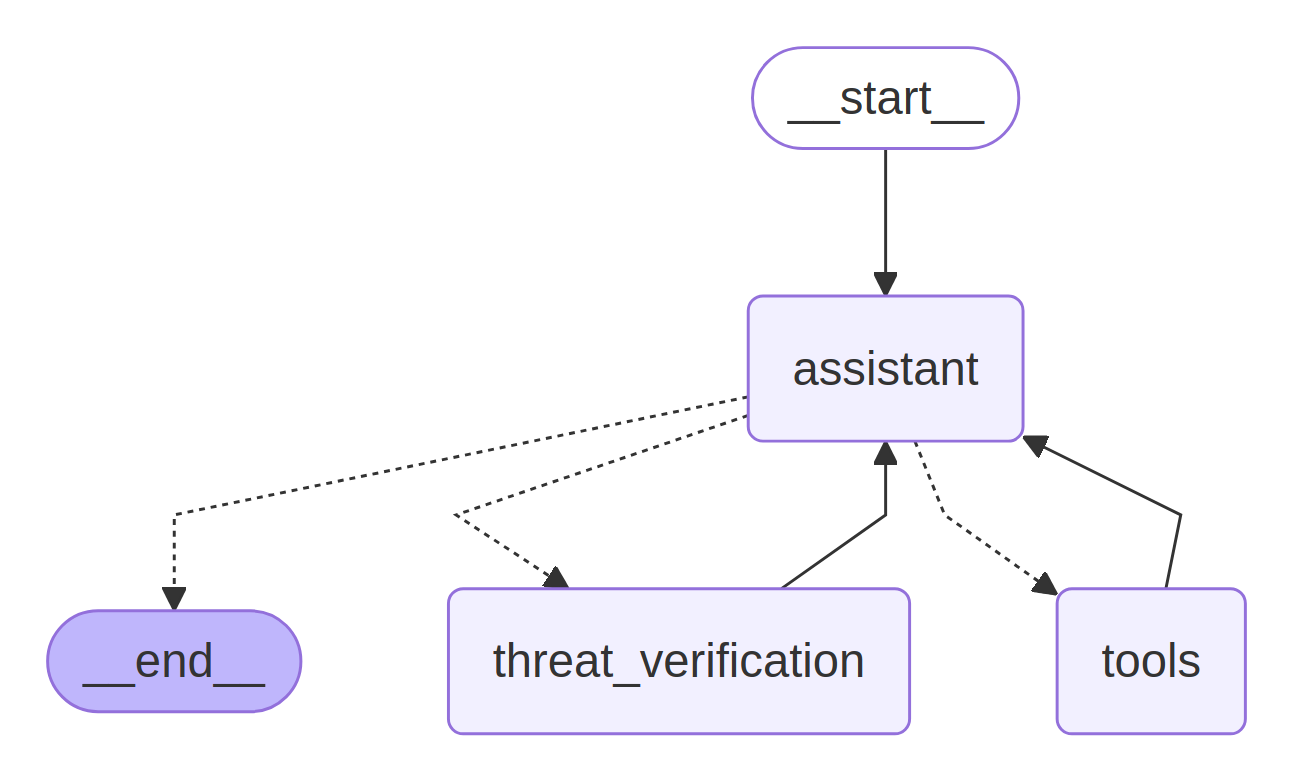

In [12]:
graph = build_react_graph()
display_graph(graph)

In [15]:
# Create an initial state
initial_state = HoneypotStateReact(
    messages="Analyze a time window of 30 minutes"
)
response = graph.invoke(initial_state)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Retrieving services status
INFO:tools:Retrieving security events (window: 30 minutes)
INFO:tools:Retrieving network flows (window: 30 minutes)
INFO:tools:Retrieving compressed packets (limit: 500, window: 30)
INFO:tools:Retrieving firewall rules...
INFO:tools:Retrieved 34 flows with 3 threat IPs
INFO:tools:Retrieved 3 threat IPs, 12 command executions, 12 total threats
INFO:tools:Successfully retrieve services health
INFO:tools:Threat details found for IPs: ['172.20.0.4', '172.20.0.5', '192.168.100.2']
INFO:tools:Retrieved 500 compressed packets, 18 with threats, 6 with command execution
INFO:tools:Successfully retrieved firewall rules
INFO:nodes:Network flows: Found threats from 3 IPs with details: ['172.20.0.4', '172.20.0.5', '192.168.100.2']


network_flows: {}

    security_events: {}

    compressed_packets: {}

    packet_summary: {}
        


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Extracted 13 threat incidents with payload for verification
INFO:nodes:Split 13 incidents into 2 chunks


network_flows: {'success': True, 'data': {'analysis_timestamp': 1749379016.7696042, 'flows': [{'applications': ['HTTP', 'HTTPS'], 'dst_ip': '172.20.0.2', 'duration': 1.3526380062103271, 'first_seen': 1749378601.800143, 'has_threats': True, 'last_seen': 1749378603.152781, 'packet_count': 16, 'ports_accessed': [80, 443], 'protocols': ['ICMP', 'TCP'], 'src_ip': '192.168.100.2', 'threat_types': []}, {'applications': ['HTTP', 'HTTPS'], 'dst_ip': '172.20.0.3', 'duration': 1.3464839458465576, 'first_seen': 1749378601.806386, 'has_threats': False, 'last_seen': 1749378603.15287, 'packet_count': 16, 'ports_accessed': [80, 443], 'protocols': ['ICMP', 'TCP'], 'src_ip': '192.168.100.2', 'threat_types': []}, {'applications': ['HTTP'], 'dst_ip': '172.20.0.4', 'duration': 24.847495794296265, 'first_seen': 1749378601.806476, 'has_threats': True, 'last_seen': 1749378626.653972, 'packet_count': 414, 'ports_accessed': [2375, 8080, 8081, 80, 43632], 'protocols': ['ICMP', 'TCP'], 'src_ip': '192.168.100.2', 

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Analyzing chunk 2/2...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


network_flows: {'success': True, 'data': {'analysis_timestamp': 1749379016.7696042, 'flows': [{'applications': ['HTTP', 'HTTPS'], 'dst_ip': '172.20.0.2', 'duration': 1.3526380062103271, 'first_seen': 1749378601.800143, 'has_threats': True, 'last_seen': 1749378603.152781, 'packet_count': 16, 'ports_accessed': [80, 443], 'protocols': ['ICMP', 'TCP'], 'src_ip': '192.168.100.2', 'threat_types': []}, {'applications': ['HTTP', 'HTTPS'], 'dst_ip': '172.20.0.3', 'duration': 1.3464839458465576, 'first_seen': 1749378601.806386, 'has_threats': False, 'last_seen': 1749378603.15287, 'packet_count': 16, 'ports_accessed': [80, 443], 'protocols': ['ICMP', 'TCP'], 'src_ip': '192.168.100.2', 'threat_types': []}, {'applications': ['HTTP'], 'dst_ip': '172.20.0.4', 'duration': 24.847495794296265, 'first_seen': 1749378601.806476, 'has_threats': True, 'last_seen': 1749378626.653972, 'packet_count': 414, 'ports_accessed': [2375, 8080, 8081, 80, 43632], 'protocols': ['ICMP', 'TCP'], 'src_ip': '192.168.100.2', 

In [16]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Analyze a time window of 30 minutes
================================== Ai Message ==================================

To begin analyzing the 30-minute time window, I must first ensure that the necessary monitoring services are operational and gather the essential information regarding the current security context. I will check the health of the services, assess security events, analyze network flows, examine compressed packet data, review the current firewall rules, and inspect the list of honeypot containers to understand their network configurations.

Let's proceed by executing the necessary tools in parallel to efficiently gather the required data.
Tool Calls:
  check_services_health (call_q11v46LvrcR6iF8COKxNu9jM)
 Call ID: call_q11v46LvrcR6iF8COKxNu9jM
  Args:
  get_security_events (call_z3RGp1DSPS8SIFJQpRTqdfBW)
 Call ID: call_z3RGp1DSPS8SIFJQpRTqdfBW
  Args:
    time_window: 30
  get_network_flows 